In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy

# **1. Get data**

In [2]:
# Step 1: Load both train and test text files
test_file_path = 'test.txt'    # Path to your test.txt file
train_file_path = 'train.txt' 
# Specify the folders for train and test images
train_dir = './Train/'  # Folder where train images are stored
test_dir = './Test/'    # Folder where test images are stored

In [3]:
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
# Load the train.txt into a pandas dataframe
train_labels = pd.read_csv(train_file_path, sep=" ", header=None, names=['image_path', 'class_label'])
test_labels = pd.read_csv(test_file_path, sep=" ", header=None, names=['image_path', 'class_label'])

# Function to load and preprocess images
def process_image(image_path, label, base_dir):
    # Concatenate the base directory with the image path using a list
    full_image_path = tf.strings.join([base_dir, image_path])
    
    # Load the image from the path
    image = tf.io.read_file(full_image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image
    # Resize the image to a fixed size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize the image to [0, 1]
    return image, label

# Create the dataset from the image paths and labels
def create_tf_dataset(image_paths, labels, base_dir):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda image_path, label: process_image(image_path, label, base_dir),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Create the TensorFlow dataset
train_dataset_full = create_tf_dataset(train_labels['image_path'], train_labels['class_label'], train_dir)
test_dataset = create_tf_dataset(test_labels['image_path'], test_labels['class_label'], test_dir)

# Split the training dataset into train and validation datasets
validation_split = 0.2
total_size = len(train_labels)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

# Shuffle and split
train_dataset_full = train_dataset_full.shuffle(buffer_size=total_size)
val_dataset = train_dataset_full.take(val_size)  # Validation set
train_dataset = train_dataset_full.skip(val_size)  # Training set

# Ensure batching and prefetching
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [5]:
# Extract the full class name by splitting the filename at '_' and slicing off the last two parts
train_labels['class_name'] = train_labels['image_path'].apply(lambda x: '_'.join(x.split('_')[:-2]))
# Create a list of unique class names in the order of their labels
class_names = train_labels[['class_name', 'class_label']].drop_duplicates().sort_values('class_label')['class_name'].tolist()
print(class_names)

['Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani', 'Crested_Auklet', 'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Yellow_headed_Blackbird', 'Bobolink', 'Indigo_Bunting', 'Lazuli_Bunting', 'Painted_Bunting', 'Cardinal', 'Spotted_Catbird', 'Gray_Catbird', 'Yellow_breasted_Chat', 'Eastern_Towhee', 'Chuck_will_Widow', 'Brandt_Cormorant', 'Red_faced_Cormorant', 'Pelagic_Cormorant', 'Bronzed_Cowbird', 'Shiny_Cowbird', 'Brown_Creeper', 'American_Crow', 'Fish_Crow', 'Black_billed_Cuckoo', 'Mangrove_Cuckoo', 'Yellow_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Purple_Finch', 'Northern_Flicker', 'Acadian_Flycatcher', 'Great_Crested_Flycatcher', 'Least_Flycatcher', 'Olive_sided_Flycatcher', 'Scissor_tailed_Flycatcher', 'Vermilion_Flycatcher', 'Yellow_bellied_Flycatcher', 'Frigatebird', 'Northern_Fulmar', 'Gadwall', 'American_Goldfinch', 'European_Goldfinch', 'Boat_tailed_Grackle', 'Eared_

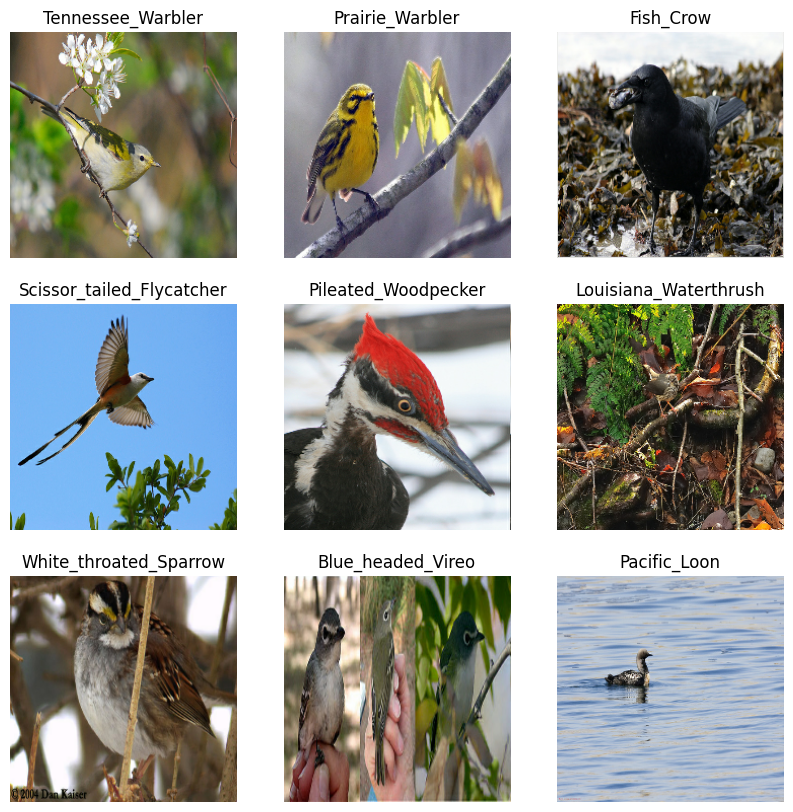

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 31
Number of testing batches: 38


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.GaussianNoise(stddev=0.1),
])

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [16]:
prediction_layer = tf.keras.layers.Dense(200, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [17]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120  

In [19]:
len(model.trainable_variables)

4

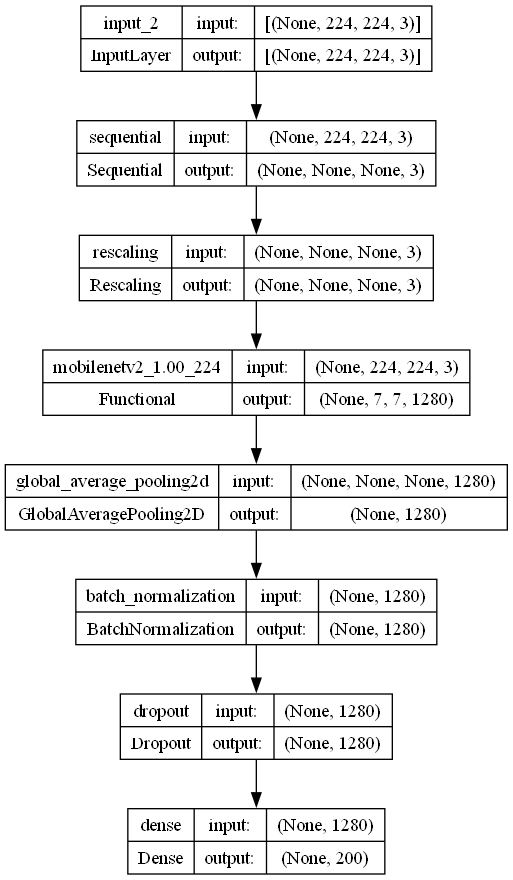

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [22]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_dataset)


31/31 [==============================] - 54s 419ms/step - loss: 5.5349 - accuracy: 0.0052


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.53
initial accuracy: 0.01


In [24]:
history_initial = model.fit(train_dataset,            
                    epochs=initial_epochs,
                    validation_data=val_dataset
                    )

Epoch 1/20
121/121 [==============================] - 156s 882ms/step - loss: 4.5443 - accuracy: 0.1084 - val_loss: 3.0107 - val_accuracy: 0.3492
Epoch 2/20
121/121 [==============================] - 97s 772ms/step - loss: 2.7149 - accuracy: 0.3377 - val_loss: 2.0814 - val_accuracy: 0.5223
Epoch 3/20
121/121 [==============================] - 203s 1s/step - loss: 2.0824 - accuracy: 0.4697 - val_loss: 1.6496 - val_accuracy: 0.5731
Epoch 4/20
121/121 [==============================] - 163s 1s/step - loss: 1.7437 - accuracy: 0.5505 - val_loss: 1.5034 - val_accuracy: 0.6093
Epoch 5/20
121/121 [==============================] - 187s 1s/step - loss: 1.5509 - accuracy: 0.5888 - val_loss: 1.2074 - val_accuracy: 0.6902
Epoch 6/20
121/121 [==============================] - 179s 1s/step - loss: 1.4067 - accuracy: 0.6299 - val_loss: 1.2070 - val_accuracy: 0.6922
Epoch 7/20
121/121 [==============================] - 145s 1s/step - loss: 1.2862 - accuracy: 0.6483 - val_loss: 1.1211 - val_accuracy: 0

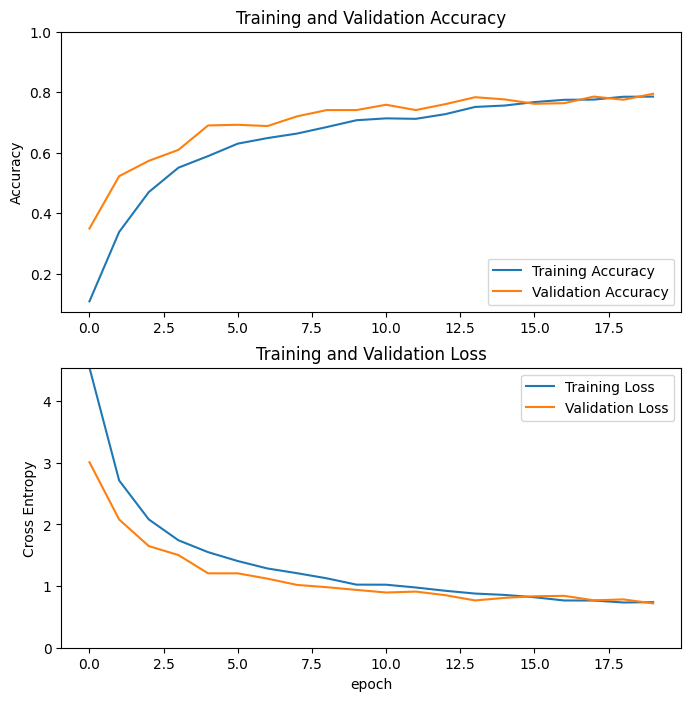

In [25]:
acc = history_initial.history['accuracy']
val_acc = history_initial.history['val_accuracy']

loss = history_initial.history['loss']
val_loss = history_initial.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120  

In [30]:
len(model.trainable_variables)

58

In [31]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history_initial.epoch),
                         validation_data=val_dataset
                         )

Epoch 21/35
121/121 [==============================] - 359s 2s/step - loss: 0.6251 - accuracy: 0.8214 - val_loss: 0.6017 - val_accuracy: 0.8394
Epoch 22/35
121/121 [==============================] - 256s 2s/step - loss: 0.6001 - accuracy: 0.8271 - val_loss: 0.5964 - val_accuracy: 0.8155
Epoch 23/35
121/121 [==============================] - 264s 2s/step - loss: 0.5650 - accuracy: 0.8269 - val_loss: 0.5263 - val_accuracy: 0.8342
Epoch 24/35
121/121 [==============================] - 260s 2s/step - loss: 0.5258 - accuracy: 0.8401 - val_loss: 0.4335 - val_accuracy: 0.8705
Epoch 25/35
121/121 [==============================] - 312s 2s/step - loss: 0.5100 - accuracy: 0.8509 - val_loss: 0.4609 - val_accuracy: 0.8736
Epoch 26/35
121/121 [==============================] - 285s 2s/step - loss: 0.4792 - accuracy: 0.8548 - val_loss: 0.4458 - val_accuracy: 0.8653
Epoch 27/35
121/121 [==============================] - 314s 2s/step - loss: 0.4791 - accuracy: 0.8551 - val_loss: 0.4884 - val_accuracy:

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

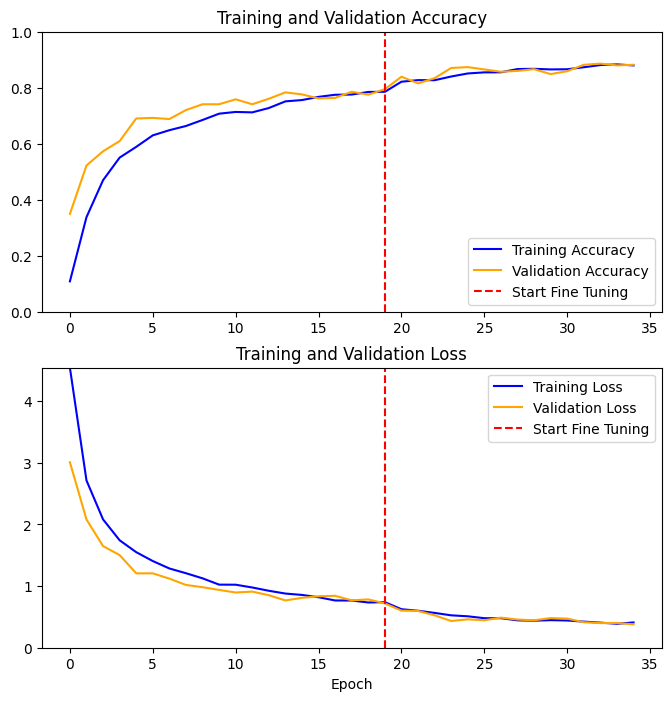

In [33]:
# Plotting
plt.figure(figsize=(8, 8))

# Plotting Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylim([0, 1])  # Adjust the y-limit to fit your data range
plt.axvline(x=initial_epochs - 1, color='r', linestyle='--', label='Start Fine Tuning')  # Vertical line for fine-tuning
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.ylim([0, max(max(loss), max(val_loss))])  # Set the y-limit based on max values
plt.axvline(x=initial_epochs - 1, color='r', linestyle='--', label='Start Fine Tuning')  # Vertical line for fine-tuning
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Initialize the accuracy metric
top_1_accuracy = Accuracy()

# Get the model predictions and true labels
predictions = []
true_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))  # Append predicted classes
    true_labels.extend(labels.numpy())  # Convert labels from TensorFlow tensor to numpy array

# Convert predictions and true labels to numpy arrays
predicted_classes = np.array(predictions)
true_labels = np.array(true_labels)

# Convert to TensorFlow tensors for accuracy calculation
test_labels_tensor = tf.convert_to_tensor(true_labels, dtype=tf.int32)
predicted_classes_tensor = tf.convert_to_tensor(predicted_classes, dtype=tf.int32)

# Compute Top-1 Accuracy
top_1_accuracy.update_state(test_labels_tensor, predicted_classes_tensor)
top_1_accuracy_result = top_1_accuracy.result().numpy()

print(f"Top-1 Accuracy: {top_1_accuracy_result * 100:.2f}%")

# Initialize variables for calculating average accuracy per class
num_classes = 200  # Example for CUB-200 dataset
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

# Calculate per-class accuracy
for i in range(len(true_labels)):
    label = true_labels[i]
    pred = predicted_classes[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

# Avoid division by zero
class_accuracies = np.zeros(num_classes)
for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracies[i] = class_correct[i] / class_total[i]

# Compute average accuracy per class
average_accuracy_per_class = np.mean(class_accuracies)
print(f"Average Accuracy Per Class: {average_accuracy_per_class * 100:.2f}%")


38/38 [==============================] - 12s 287ms/step - loss: 1.9085 - accuracy: 0.5756
Test loss: 1.9085242748260498
Test accuracy: 0.5755813717842102
1/1 [==============================] - 1s 942ms/step
Top-1 Accuracy: 57.56%
Average Accuracy Per Class: 56.91%
